<a href="https://colab.research.google.com/github/mschrader15/homework/blob/main/spring-2022/ece-693/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction to homework**
This homework explores conditional GAN that produces images conditioned on class labels. This homework is based on the example by Sayak Paul available at https://keras.io/examples/generative/conditional_gan/

"Generative Adversarial Networks (GANs) let us generate novel image data, video data,
or audio data from a random input. Typically, the random input is sampled
from a normal distribution, before going through a series of transformations that turn
it into something plausible (image, video, audio, etc.).

However, a simple [DCGAN](https://arxiv.org/abs/1511.06434) doesn't let us control
the appearance (e.g. class) of the samples we're generating. For instance,
with a GAN that generates MNIST handwritten digits, a simple DCGAN wouldn't let us
choose the class of digits we're generating.
To be able to control what we generate, we need to _condition_ the GAN output
on a semantic input, such as the class of an image."

In this homework, you'll train a **Conditional GAN** that can generate food images of a given class.

The original MNIST example is based on these references:

* [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)
* [Lecture on Conditional Generation from Coursera](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/conditional-generation-inputs-2OPrG)

For a description of GANs, you can refer to the "Generative adversarial networks"
section of
[this resource](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/r-3/232).

This homework requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

### Install the Necessary Libraries

In [195]:
%pip install -q git+https://github.com/tensorflow/docs

Note: you may need to restart the kernel to use updated packages.


## Imports

In [196]:
import os
from mpl_toolkits.axes_grid1 import ImageGrid


from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio


## Constants and hyperparameters

In [17]:
batch_size = 100
# RGB
num_channels = 3
num_classes = 10
image_size = 32
latent_dim = 110

IMG_SIZE = (image_size, image_size)


## Loading the dataset and preprocessing it




### **Assignment dataset**

Note that below is the original code for loading the MNIST dataset. In this homework you could use **one** of the following:
1. CIFAR10 dataset. This dataset is included with Keras, See https://keras.io/api/datasets/cifar10/
2. Cats and Dogs dataset. This dataset is available from Kaggle. The textbook has examples of working with this dataset in the image classification section. https://www.kaggle.com/competitions/dogs-vs-cats/data
3. Food101 dataset, also available from Kaggle. https://www.kaggle.com/datasets/kmader/food41

Regardless of the dataset you choose, a couple of important considerations:
- Unlike the MNIST example, these are color images and the GAN should be able to produce color images.
- Keep the image resolution and number of classes manageable, otherwise the network will take too long or will not properly train.

**Modify the code below to load the dataset of your choice**

Please either use wget links or include the data in the same directory as your code.
Note that I'll not be able to access files mounted on your Google drive, so the data should be local to the runtime instance!!! You could use wget or gdown to download required files.

### Store the File Paths

In [25]:
ROOT = os.path.abspath("")
TEST_DATA = os.path.join(ROOT, "data", "test1")
TRAIN_DATA = os.path.join(ROOT, "data", "train")


### Load the CIFAR10 Dataset

In [43]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = np.concatenate([x_train, x_test], axis=0)
y_train = np.concatenate([y_train, y_test], axis=0)
x_train = (x_train.astype("float32") - 127.5) / 127.5


#### Create a Pre-Processing Layer

In [44]:
preprocessing_layer = keras.Sequential(
    [
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.3),
        tf.keras.layers.RandomZoom(0.1),
    ]
)


#### Loading the Datasets onto GPU

In [46]:
labels = keras.utils.to_categorical(y_train, num_classes)

# # Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((x_train, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
dataset = dataset.map(lambda x, y: (preprocessing_layer(x), y))
dataset = dataset.prefetch(tf.data.AUTOTUNE)

print(f"Shape of training images: {x_train.shape}")
print(f"Shape of training labels: {labels.shape}")


Shape of training images: (60000, 32, 32, 3)
Shape of training labels: (60000, 10)


### Plotting Image to Ensure Everything OK

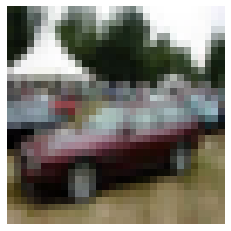

In [47]:
import matplotlib.pyplot as plt

# plotting the data augmentation and the color distortion
# plt.figure(figsize=(1, 1))
# plt.figure()
for images, _ in dataset.take(1):
    # augmented_images = data_augementation()(images)
    # ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[0].numpy() * 127.5 + 127.5).astype(np.uint8))
    plt.axis("off")


## Calculating the number of input channel for the generator and discriminator

In a regular (unconditional) GAN, we start by sampling noise (of some fixed
dimension) from a normal distribution. In our case, we also need to account
for the class labels. We will have to add the number of classes to
the input channels of the generator (noise input) as well as the discriminator
(generated image input).

In [48]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)


120 13


## Creating the discriminator and generator

The model definitions (`discriminator`, `generator`, and `ConditionalGAN`) have been
adapted from [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

Note that you need to adjust these models for work with color images.

In [57]:

discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((*IMG_SIZE, discriminator_in_channels)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(generator_in_channels,)),
        layers.Dense(
            4 * 4 * (IMG_SIZE[0] * 12),
            input_dim=generator_in_channels,
            activation="relu",
            kernel_initializer="glorot_normal",
            bias_initializer="Zeros",
        ),
        layers.Reshape((4, 4, IMG_SIZE[0] * 12)),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(
            IMG_SIZE[0] * 6,
            kernel_size=5,
            strides=2,
            padding="same",
            activation="relu",
            kernel_initializer="glorot_normal",
            bias_initializer="Zeros",
        ),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(
            IMG_SIZE[0] * 3,
            kernel_size=5,
            strides=2,
            padding="same",
            activation="relu",
            kernel_initializer="glorot_normal",
            bias_initializer="Zeros",
        ),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(
            3,
            kernel_size=5,
            strides=2,
            padding="same",
            activation="tanh",
            kernel_initializer="glorot_normal",
            bias_initializer="Zeros",
        ),
    ],
    name="generator",
)


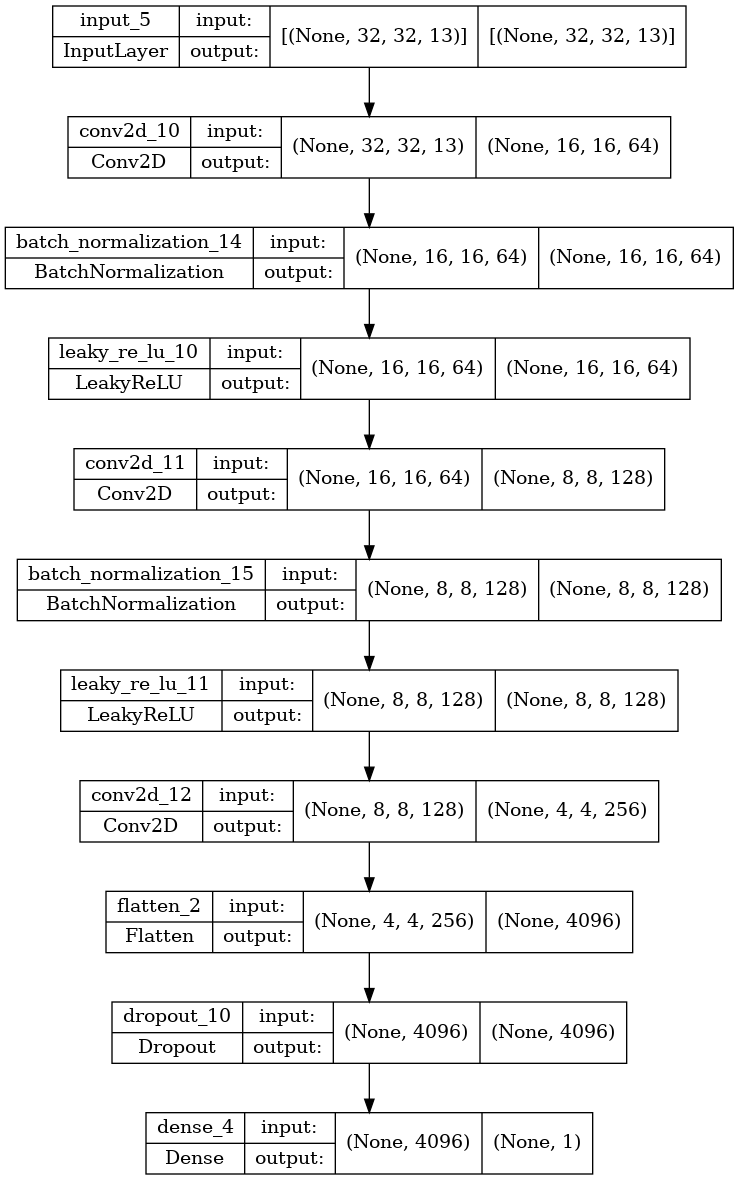

In [58]:
tf.keras.utils.plot_model(discriminator, show_shapes=True)


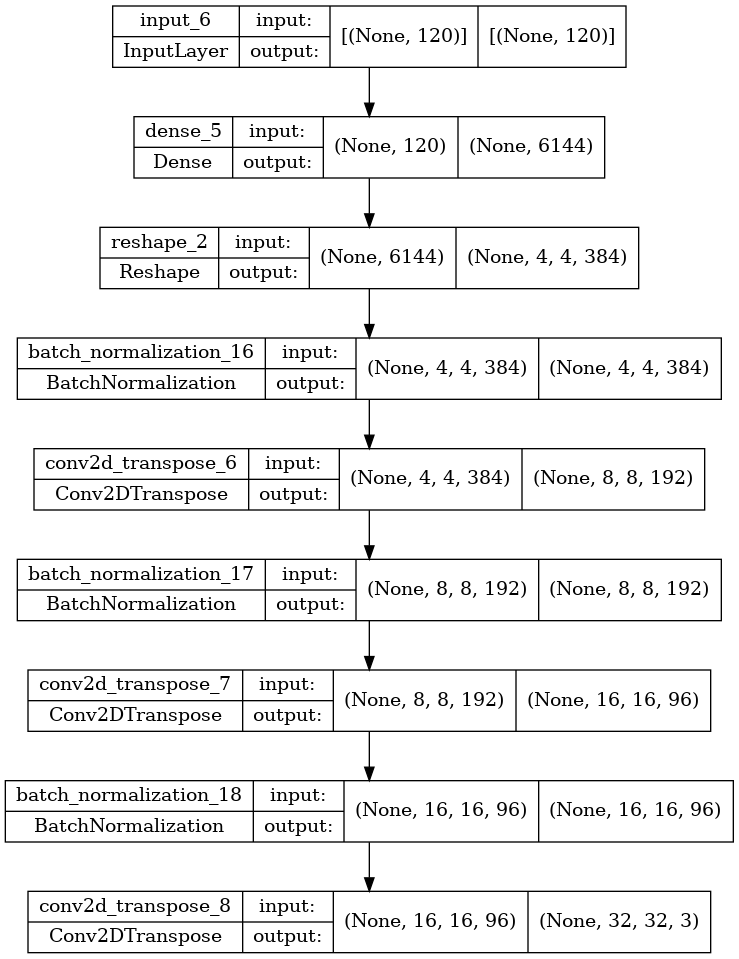

In [59]:
tf.keras.utils.plot_model(generator, show_shapes=True)


## Creating a `ConditionalGAN` model

In [60]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Training the Conditional GAN

**Do not forget to save the model after training and include the model with the submission**

In [61]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim - num_classes)
        )
        first_label = tf.cast(
            keras.utils.to_categorical([np.random.randint(0, 10)], num_classes),
            tf.float32,
        )
        random_latent_vectors = tf.concat([random_latent_vectors, first_label], 1)

        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images.numpy()

        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i] * 127.5 + 127.5)
            img.save(os.path.join(ROOT, "data", f"generated_img_{epoch:03d}_{i}.png"))


In [62]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

cond_gan.fit(
    dataset,
    epochs=500,
    callbacks=[GANMonitor(num_img=1, latent_dim=generator_in_channels)],
)


Epoch 1/500
600/600 [==============================] - 14s 22ms/step - g_loss: 3.3013 - d_loss: 0.3169
Epoch 2/500
600/600 [==============================] - 13s 22ms/step - g_loss: 1.5829 - d_loss: 0.5238
Epoch 3/500
600/600 [==============================] - 13s 22ms/step - g_loss: 1.2084 - d_loss: 0.6015
Epoch 4/500
600/600 [==============================] - 13s 22ms/step - g_loss: 1.2490 - d_loss: 0.5904
Epoch 5/500
600/600 [==============================] - 13s 22ms/step - g_loss: 1.1978 - d_loss: 0.5949
Epoch 6/500
600/600 [==============================] - 13s 22ms/step - g_loss: 1.1141 - d_loss: 0.6245
Epoch 7/500
600/600 [==============================] - 13s 22ms/step - g_loss: 1.2188 - d_loss: 0.5992
Epoch 8/500
600/600 [==============================] - 13s 22ms/step - g_loss: 1.2523 - d_loss: 0.5914
Epoch 9/500
600/600 [==============================] - 13s 22ms/step - g_loss: 1.1343 - d_loss: 0.6052
Epoch 10/500
600/600 [==============================] - 13s 22ms/step - g

### Save the GAN Layers

In [190]:
# cond_gan.generator.save_weights("generator_test_weights.keras")
# cond_gan.discriminator.save_weights("discriminator_test_weights.keras")
cond_gan.generator.save("generator_final.h5")
cond_gan.discriminator.save("discriminator_final.h5")


## Interpolating between classes with the trained generator

**Load the model from the file, generate images**

Note that the class choice may be set the same for start_class and end_class. In this case generate 1 image of the target class.

### Loading the Model from the Disk

In [193]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = keras.models.load_model("generator_final.h5")
trained_gen.compile()


### Plotting the GAN

In [194]:
# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 10  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    return trained_gen.predict(noise_and_labels)


start_class = 0  # @param {type:"slider", min:0, max:9, step:1}
end_class = 9  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)


Here, we first sample noise from a normal distribution and then we repeat that for
`num_interpolation` times and reshape the result accordingly.
We then distribute it uniformly for `num_interpolation`
with the label indentities being present in some proportion.


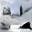

In [183]:
# fake_images *= 255.0
# converted_images = fake_images.astype(np.uint8)
converted_images = (
    tf.image.resize(fake_images, IMG_SIZE).numpy() * 127.5 + 127.5
).astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")


### 500 Iteration Predictions

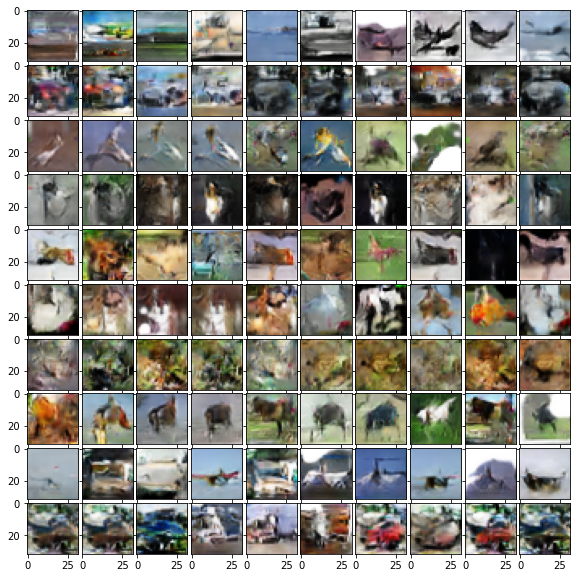

In [198]:
rows = []
for k in range(10):
    interpolation_noise = tf.random.normal(shape=(10, latent_dim))
    sampled_labels = tf.repeat(keras.utils.to_categorical([k], num_classes), 10, 0)
    rows.append(tf.concat([interpolation_noise, sampled_labels], 1))


generated_images = []
for noise_l in rows:
    generated_images.extend(trained_gen.predict(noise_l))


fig = plt.figure(figsize=(10.0, 10.0))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(10, 10),  # creates 2x2 grid of axes
    axes_pad=0.05,  # pad between axes in inch.
)

for ax, im in zip(grid, generated_images):
    # Iterating over the grid returns the Axes.
    ax.imshow((im * 127.5 + 127.5).astype(np.uint8))
    plt.axis("off")


We can further improve the performance of this model with recipes like
[WGAN-GP](https://keras.io/examples/generative/wgan_gp).
Conditional generation is also widely used in many modern image generation architectures like
[VQ-GANs](https://arxiv.org/abs/2012.09841), [DALL-E](https://openai.com/blog/dall-e/),
etc.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/conditional-gan) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conditional-GAN).

# **Grading**

*   (10 pts) Report quality / submission requirement followed (see class policy)
*   (90 pts) Correctness of the implementation. The basis is ability of the network to generate coherent shapes that may remotely resemble instances of the target class (as opposed to random noise).
*   (10 pts bonus) Explore how **one** of the following affects the realism of image generattion: 1) number of classes; 2) size of the latent dimension; 3) image resolution; 4) increasing the depth / layer type (e.g. implementing residual connections) of the discriminator



## Report

### Introduction

Homework 5 asked us to investigate conditional generative adverserial networkz (GAN) by selecting a dataset and trying to generate images for each class in the dataset. I chose to use the CIFAR10 dataset as it had low resolution (32x32) which led to faster training times. 

### Methods

The first step in the GAN process was to load the data. Luckily, keras has a simplified method to pull the CIFAR10 dataset, so it is simply a single function call to fetch the data. I was able to concatenate both the test data to the train data, because our GAN doesn't utilize a test/train/validation split in the traditional sense. After extending the training data, the input was normalized and used to create a tensorflow dataset. I applied several transforms to the dataset, including rotation and flips. I found that adding these input transforms helped the GAN converge on more realistic images.

Then the discriminator and generator layers were created. I added several layers to the generator as well as played around with the activation and kernel initialization. Then the model was trained with a custom callback that created an image for every epoch of training. The model was trained for 500 epochs.

### Results

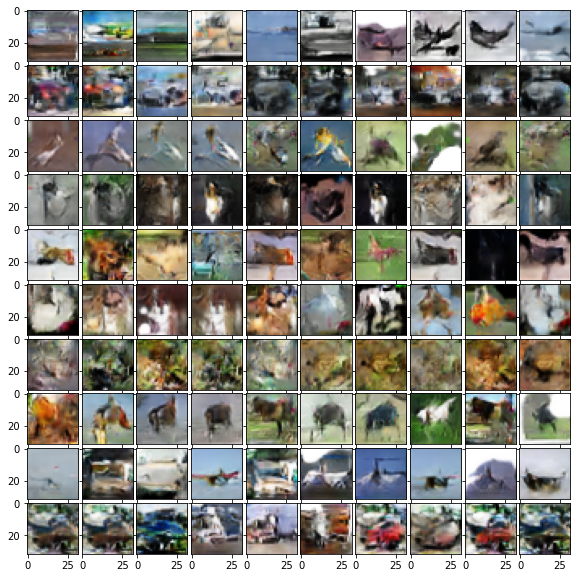

In [200]:
fig

### Conclusion

GANs were a fun project. At the same time, they take a long time to train. I imitially started with the Cats and Dogs dataset, which I downsampled to 64 x 64, however it still took a long time to train. I switched to CIFAR and had more reasonable training times (~2 hours). 

In the end, my results after 500 epochs of training showed a definite difference between the classes. Some of the classes show resemblence to the actual category. For example. I think that the horse category turned out good, as did the car category. 